In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
import os
import collections
import itertools

In [7]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.io as spio
import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data

In [8]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

In [9]:
from six.moves import urllib

In [21]:
mnist = input_data.read_data_sets('mnist_data/', one_hot=True)

Extracting mnist_data/train-images-idx3-ubyte.gz
Extracting mnist_data/train-labels-idx1-ubyte.gz
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Extracting mnist_data/t10k-labels-idx1-ubyte.gz


In [22]:
def display_digit(digit):
    plt.imshow(digit.reshape(28, 28), cmap='Greys',interpolation='nearest')

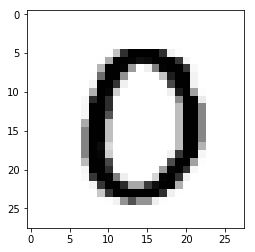

In [23]:
display_digit(mnist.train.images[10])

In [24]:
height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_featrure_maps = 32
conv1_kernel_size = 3
conv1_stride = 1
conv1_pad = 'SAME'

conv2_featrure_maps = 64
conv2_kernel_size = 3
conv2_stride = 2
conv2_pad = 'SAME'

pool3_feature_maps = conv2_featrure_maps

n_fullyconn1 = 64
n_outputs = 10

In [25]:
def build_cnn(features):
    X = tf.reshape(features['images'], shape=[-1, height, width, channels])
    
    conv1 = tf.layers.conv2d(X, filters=conv1_featrure_maps,
                            kernel_size=conv1_kernel_size,
                            strides=conv1_stride, padding=conv1_pad,
                            activation=tf.nn.relu)
    
    conv2 = tf.layers.conv2d(conv1, filters=conv2_featrure_maps,
                            kernel_size=conv2_kernel_size, 
                            strides=conv2_stride, padding=conv2_pad,
                            activation=tf.nn.relu)
    
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='VALID')
    
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_feature_maps * 7 * 7])
    
    fullyconn1 = tf.layers.dense(pool3_flat, n_fullyconn1,
                                activation=tf.nn.relu)
    
    logits = tf.layers.dense(fullyconn1, n_outputs)
    
    return logits

In [26]:
def cnn_model_fn(features, labels, mode):
    logits = build_cnn(features)
    predicted_classes = tf.argmax(logits, axis=1)
    
    # prediction mode
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=predicted_classes)
    
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits, labels=tf.cast(labels, dtype=tf.int32)))
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
    
    # training mode
    if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)
    
    # Evaluation mode
    accuracy = tf.metrics.accuracy(labels=labels, predictions=predicted_classes)
    
    return tf.estimator.EstimatorSpec(
        mode=mode,
        predictions=predicted_classes,
        train_op=train_op,
        loss=loss,
        eval_metric_ops={'accuracy': accuracy})

In [27]:
num_steps = 2000
batch_size = 100

In [28]:
model = tf.estimator.Estimator(cnn_model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp0fxn2wtb', '_num_ps_replicas': 0, '_master': '', '_is_chief': True, '_task_type': 'worker', '_session_config': None, '_service': None, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_save_summary_steps': 100, '_log_step_count_steps': 100, '_num_worker_replicas': 1, '_tf_random_seed': None, '_keep_checkpoint_every_n_hours': 10000, '_keep_checkpoint_max': 5, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fdf03f7bf98>, '_task_id': 0}


In [29]:
input_fn = tf.estimator.inputs.numpy_input_fn(
        x = {'images': mnist.train.images}, y = mnist.train.labels,
        batch_size=batch_size, num_epochs=None, shuffle=True)

In [30]:
model.train(input_fn, steps=num_steps)

ValueError: Rank mismatch: Rank of labels (received 2) should equal rank of logits minus 1 (received 2).